# Vehicle Routing Problem (VRP)

The Vehicle Routing Problem (VRP) is a combinatorial optimization problem that aims to determine the optimal routes for a fleet of vehicles to deliver goods to a set of locations while minimizing the total distance traveled or cost incurred. The problem is NP-hard, meaning that finding an exact solution is computationally infeasible for large instances, and heuristic or approximation algorithms are often used to find near-optimal solutions.

The tutorial showcases how to solve the problem using the Quantum Approximate Optimization Algorithm (QAOA).

In the problem, each vehicle starts from a different depot, visits a set of cities, and returns to its depot. The goal is to minimize the total travel cost while ensuring that each city is visited exactly once by one vehicle.

## Mathematical Formulation

Given:

- A set of locations:
    $L = {0, 1, \dots, n-1}$ where <br>
    - The first $m$ locations are depots: 
    $D = {0, 1, \dots, m-1}$ <br>
    - The remaining $n - m$ are cities:
    $C = {m, m+1, \dots, n-1}$
- Each vehicle $k \in D$:<br>
    - Starts and ends its route at its own depot $k$
    - Visits a sequence of cities
    - Returns to its depot
- Each city must be visited exactly once by one vehicle only.
- Each vehicle route has $P = p + 2$ positions (start + $p$ inner positions + end). You can think about the positions as timesteps. The variable are called `positions` because driving between cities does not take the same amount of time.

### Decision Variables
Let $x_{u,v}^k \in \{0,1\}$ be a binary variable defined as

$$
x_{u,v}^k =
\begin{cases}
1 & \text{if vehicle } k \text{ visits location } u \text{ at position } v \\
0 & \text{otherwise}
\end{cases}
$$

where:<br>
$u \in L$ (location: city or depot)<br>
$v \in {0, 1, \dots, P - 1}$<br>
$k \in D$ (vehicle/depot index)

### Constraints
1. Each city is visited exactly once:
$$
\sum_{k\in D}\sum_{v=1}^{P-2} x_{u,v}^k = 1 \,\,\,\,\forall u\in C
$$
Each city appears in exactly one vehicle's route, and not at the start or end positions.<br>
2. Each car visits exactly one city in every position:
$$
\sum_{u\in C} x_{u,v}^k = 1 \,\,\,\,\forall v\in \{1,\dots,P-2\},\,\,\forall k\in D
$$

    Each vehicle has exactly one location assigned to each inner route position.<br>
3. Depot start and end positions are fixed:
$$
x_{k,0}^k = x_{k,P-1}^k = 1 \,\,\,\, \forall k\in D
$$
$$
x_{u,0}^k = x_{u,P-1}^k = 0 \,\,\,\, for \,\,\, u\neq k
$$
Each vehicle starts and ends at its own depot only.

4. No city is at the start or end:
$$
x_{u,0}^k = x_{u,P-1}^k = 1 \,\,\,\, \forall u\in C \,\,\,\, \forall k\in D
$$
    **Constraints (3) and (4) do not use qubits in the QAOA circuit, because they are predetermined.** 


### Objective Function

The aim is to minimize total travel cost, defined as

$$
\min_x \quad \sum_{k \in D} \sum_{v = 0}^{P - 2} \sum_{u \in L} \sum_{w \in L} \text{dist}(u, w) \cdot x_{u,v}^k \cdot x_{w,v+1}^k
$$

where:
- $\text{dist}(u, w)$ is the Euclidean distance between locations $u$ and $w$.
- The sum computes all transitions $(u \rightarrow w)$ for each vehicle between consecutive positions.

### Constraint Functions

All cities are visited only once:

$$
\sum_{u \in C} \left( \sum_{k \in D} \sum_{v=0}^{P-2} x_{u,v}^k -1 \right)^2=0
$$

All positions are occupied only once:

$$
\sum_{k \in D} \sum_{v=1}^{P-2} \left(\sum_{u \in C} x_{u,v}^k -1 \right)^2=0
$$

**These are added as penalty terms and multiplied by a scaling factor later on in the `cost` function. Ensure they are actually equal to zero by adding them as penalty terms.**

## Generating Problem Data

In [119]:
import itertools
import math
from typing import Iterable

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.optimize import minimize

from classiq import *

locations = list(range(6))

# one depot per car
depots = list(range(2))

# 4 cities to visit in total
cities = list(range(2, 6))

num_vehicles = len(depots)
num_cities = len(cities)
num_locations = len(locations)

### Defining Positions
Assuming the cities are more or less evenly divided among the vehicles, use `possible_number_of_cities_per_vehicle`:

In [120]:
possible_number_of_cities_per_vehicle = len(cities) // num_vehicles

The total number of positions `num_positions` (or time slots) in a car route. Add $2$ for the start (depot) and end (return to depot) positions:

In [121]:
num_positions = possible_number_of_cities_per_vehicle + 2

All valid routes (time slots) positions that a vehicle can take:
- Starting depot $\rightarrow 0$
- Visiting cities $\rightarrow 1,2, \ldots,$ `num_positions-1`
- Ending depot $\rightarrow$ `num_positions`

In [122]:
positions_all = list(range(num_positions))

In [123]:
print(positions_all)

[0, 1, 2, 3]


The inner positions are the positions that can be occupied by cities, excluding the start and end depots.

In [124]:
inner_positions = list(range(1, num_positions - 1))

print(inner_positions)

[1, 2]


### Setting City Locations

Set random locations in a square of size `(0, max_x_y)`$\times$`(0, max_x_y)`.
To have the same result, set the random seed. To have different results, change or delete the seed:

In [125]:
np.random.seed(10)

max_x_y = 10
x_y_locations = np.random.rand(num_locations, 2) * max_x_y

Text(0.5, 1.0, 'Graph of the Cities on the XY Plane')

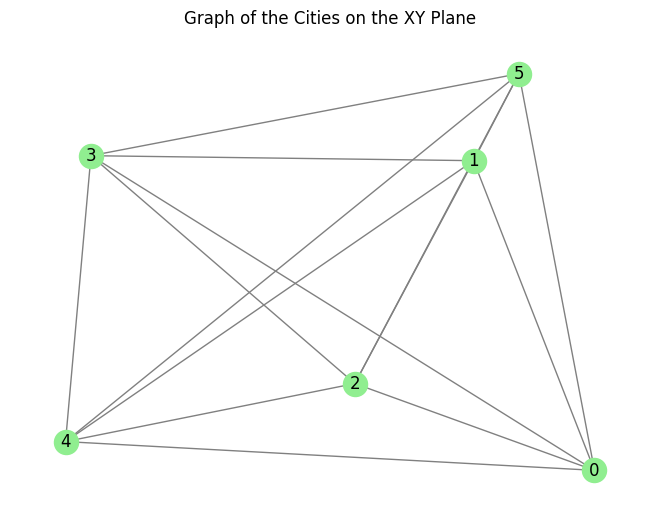

In [126]:
# Create a complete graph
G = nx.complete_graph(num_locations)

# Map node positions to the generated x_y coordinates
pos = {i: (x_y_locations[i][0], x_y_locations[i][1]) for i in range(num_locations)}

# Plot
nx.draw(
    G, pos, with_labels=True, node_size=300, node_color="lightgreen", edge_color="gray"
)
plt.title("Graph of the Cities on the XY Plane")

In [127]:
def find_xy_distances_from_locations(x_y_locations: np.ndarray):
    city_distance_matrix = np.zeros((num_locations, num_locations))
    for i in range(num_locations):
        for j in range(num_locations):
            distance = math.sqrt(
                (x_y_locations[i][0] - x_y_locations[j][0]) ** 2
                + (x_y_locations[i][1] - x_y_locations[j][1]) ** 2
            )
            city_distance_matrix[i][j] = distance
    return city_distance_matrix


def calculate_distances_between_cities(x_y_locations: np.ndarray):
    city_distance_matrix = find_xy_distances_from_locations(x_y_locations)
    max_distance = np.max(city_distance_matrix)
    min_distance = np.min(
        city_distance_matrix[city_distance_matrix > 0]
    )  # Exclude self-distances
    return city_distance_matrix, max_distance, min_distance


city_distance_matrix, max_distance, min_distance = calculate_distances_between_cities(
    x_y_locations
)

In [128]:
print(city_distance_matrix)

[[ 0.          7.40954323  3.40678023  9.35893743  6.05990735  9.3659449 ]
 [ 7.40954323  0.          5.41153153  4.35743196  8.07469987  2.11023545]
 [ 3.40678023  5.41153153  0.          6.14229335  3.56542154  7.52174929]
 [ 9.35893743  4.35743196  6.14229335  0.          6.72814108  5.24074724]
 [ 6.05990735  8.07469987  3.56542154  6.72814108  0.         10.07388021]
 [ 9.3659449   2.11023545  7.52174929  5.24074724 10.07388021  0.        ]]


The maximal cost of any candidate is `num_locations`$\times$ `max_distance`.
The minimal cost of any candidate is `num_locations`$\times$ `min_distance`.
Hence, this is the maximal difference of eigenvalues of the total cost Hamiltonian:

In [129]:
DISTANCE_NORMALISATION = num_locations * (max_distance - min_distance)

To set the maximal difference of eigenvalues of the total cost Hamiltonian to 1, scale the distances by `DISTANCE_NORMALISATION`:

In [130]:
city_distance_matrix = city_distance_matrix / DISTANCE_NORMALISATION

In [131]:
print(city_distance_matrix)

[[0.         0.15507019 0.0712986  0.19586797 0.12682441 0.19601462]
 [0.15507019 0.         0.11325492 0.09119426 0.16899088 0.04416394]
 [0.0712986  0.11325492 0.         0.12854862 0.07461871 0.15741848]
 [0.19586797 0.09119426 0.12854862 0.         0.1408095  0.10968067]
 [0.12682441 0.16899088 0.07461871 0.1408095  0.         0.2108306 ]
 [0.19601462 0.04416394 0.15741848 0.10968067 0.2108306  0.        ]]


## Normalizing the Cost and Mixer Hamiltonians
**This normalization improves the probability of finding good solutions.**
If this is too much information right now, skip it and focus on the VRP problem itself under "Defining the VRP Objective Function".

The mixer Hamiltonian is effectively $X/2$ and has eigenvalues $-0.5$ and $+0.5$. So the difference between minimum and maximum eigenvalues is exactly 1.
You can rescale it using a global scaling parameter:

In [132]:
GLOBAL_SCALING_PARAMETER = 0.1

The cost Hamiltonian should be similar in eigenvalue difference to the mixer Hamiltonian and should be normalized to about 1.
The distance normalization will take care of it later.

To find the exact normalization requires solving this NP-hard problem, so always use approximation. Since it is approximate, you can tweak the relative scaling parameter.

In [133]:
RELATIVE_OBJECTIVE_NORMALISATION = 1.5

The overall normalization of the total cost is therefore:

In [134]:
ABSOLUTE_OBJECTIVE_NORMALISATION = (
    GLOBAL_SCALING_PARAMETER * RELATIVE_OBJECTIVE_NORMALISATION
)
print(ABSOLUTE_OBJECTIVE_NORMALISATION)

0.15000000000000002


The constraint Hamiltonian has the property that a minimal constraint violation is 1 and no constraint violation is 0.
Normalize the constraint Hamiltonian relative to the total cost Hamiltonian such that the constraint violation is 1~2 x larger than the maximal difference between total cost values:

In [135]:
RELATIVE_CONSTRAINT_NORMALISATION = 6

The overall normalization of the constraint Hamiltonian is similarly:

In [136]:
ABSOLUTE_CONSTRAINT_NORMALISATION = (
    RELATIVE_CONSTRAINT_NORMALISATION * ABSOLUTE_OBJECTIVE_NORMALISATION
)

print(ABSOLUTE_CONSTRAINT_NORMALISATION)

0.9000000000000001


The normalization coefficients are hyperparameters that can be tuned to improve the performance of QAOA.
Summarize the normalization coefficients together with the cost and mixer Hamiltonians:
$$
H = C_{gsp} \cdot \left(\beta\cdot H_{mixer} + \gamma \cdot C_{ron} \left(H_{objective} + C_{rcn}\cdot H_{constraints}\right)\right)
$$

Where $\beta$ and $\gamma$ are the QAOA's variational parameters. $C_{gsp}$ is the global scaling parameter, $C_{ron}$ is the relative objective normalization, and $C_{rcn}$ is the relative constraint normalization coefficients. This method normalizes both the entire Hamiltonian and each individual term—including the constraint Hamiltonian to ensure the solution satisfies the constraints, and the objective Hamiltonian to increase the probability of finding the optimal objective value.

## Defining the VRP Objective Function
First, define number of functions that comprise the objective function.

A major difficulty is to map 3D (city, position, vehicle) to 1D index in the array of decision variables.

### Finding the Right Index in the Array
Access the value of the binary decision variable x that encodes whether city (or depot) `u` is visited at position `v` by vehicle `k`.

- `u` - city
- `v` - position (time slot)
- `x` - the array of decision variables
- `k` - the vehicle number 

In [137]:
def visit_indicator(
    x: QArray[QBit] | Iterable[int],  # array of decision variables
    u: int,  # city
    v: int,  # position
    k: int,  # vehicle number
) -> int | QBit:
    if u in depots or (v == 0 or v == num_positions - 1):
        # Case 1: If `u` is a depot
        if u in depots:
            if k == u:
                # Depots are only valid at start or end positions
                if v == 0 or v == num_positions - 1:
                    # Vehicle `k` starts or ends at its depot `u`
                    return 1
                else:
                    return 0
            else:
                return 0
        # Case 2: `u` is not a depot but the position is a depot-only position
        # Cities are not allowed at start or end of a route
        else:
            return 0
    # Handle city logic (when `u` is a city and `v` is an inner position)
    else:
        # Map 3D (city, position, vehicle) to 1D index
        city_index = u - num_vehicles
        pos_index = v - 1
        flat_index = (
            city_index * possible_number_of_cities_per_vehicle * num_vehicles
            + pos_index * num_vehicles
            + k
        )
        return x[flat_index]

Make sure to satisfy these constraints:
- Each city is assigned to exactly one vehicle and one route position.
- Each inner position of a route (per vehicle) is filled by exactly one city.

In [138]:
def check_validity(x: QArray[QBit]):
    """
    verifies that the assignment array `x` satisfies basic constraints.
    Checks if each city is visited exactly once and by one vehicle.
    """
    # Check that each city is visited exactly once
    for city_index in range(num_cities):
        assignment_sum = 0

        for position in range(
            possible_number_of_cities_per_vehicle
        ):  # inner positions only
            for vehicle_id in range(num_vehicles):
                # Shift city index by num_vehicles to access location ID (since cities start after depots)
                assignment_sum += visit_indicator(
                    x=x, u=city_index + num_vehicles, v=position + 1, k=vehicle_id
                )

        # A city must appear exactly once across all vehicles and positions
        if assignment_sum != 1:
            return False

    # Each position is used exactly once per vehicle
    for position in range(possible_number_of_cities_per_vehicle):  # inner positions
        for vehicle_id in range(num_vehicles):
            assignment_sum = 0

            for city_index in range(num_cities):
                assignment_sum += visit_indicator(
                    x=x, u=city_index + num_vehicles, v=position + 1, k=vehicle_id
                )

            # Each position must be occupied by exactly one city
            if assignment_sum != 1:
                return False

    return True

### Determining Total Travel Cost for All Vehicle Routes

In [139]:
def travel_objective_function(x: QArray[QBit]):
    """
    Computes the total travel cost for all vehicle routes defined by the assignment array `x`.

    The cost is calculated as the sum of the distances between every pair of consecutive locations
    visited by the same vehicle, across all route positions.
    """
    total_travel_cost = 0

    # Loop through each position in the route except the last (look ahead to position + 1)
    for position in range(num_positions - 1):

        # Consider every pair of locations
        for to_location in locations:
            for from_location in locations:
                # For each vehicle (indexed by its depot ID)
                for vehicle_id in depots:

                    # Add cost only if both transitions are selected in the route
                    total_travel_cost += (
                        city_distance_matrix[from_location][to_location]
                        * visit_indicator(x, from_location, position, vehicle_id)
                        * visit_indicator(x, to_location, position + 1, vehicle_id)
                    )

    return total_travel_cost

### Defining Constraints

In [140]:
def constraint_each_city_visited_once(x: QArray[QBit]):
    """
    Soft constraint: Ensures that each city is visited exactly once by applying a penalty
    for any deviation from that condition.

    For each city, it checks how many times the city appears across all vehicle routes and
    inner positions. If the count is not exactly one, a quadratic penalty term is applied.
    """
    total_deviations = 0

    # Loop over each city (cities are defined separately from depots)
    for city_id in cities:
        city_assignment_count = 0

        # Sum appearances of this city across all vehicles and inner positions
        for vehicle_id in depots:
            for position in inner_positions:
                city_assignment_count += visit_indicator(
                    x=x, u=city_id, v=position, k=vehicle_id
                )

        # Ideal count is 1: each city should be visited exactly once
        deviation_from_expected = city_assignment_count - 1

        # Apply a quadratic penalty for deviation (0 if exactly one visit)
        # Power of two ignores the sign
        penalty_term = deviation_from_expected**2

        total_deviations += penalty_term

    return total_deviations


def constraint_each_position_occupied_by_one_city(x: QArray[QBit]):
    """
    Soft constraint: Ensures that each inner position in each vehicle's route is occupied
    by exactly one location (either a city or a depot).

    For each vehicle and each inner route position, the function counts how many locations
    are assigned to that slot. If the count is not exactly one, a quadratic penalty
    term is applied from the expected value.
    """
    total_deviations = 0

    # Loop through each inner position (excluding start and end depot slots)
    for position in inner_positions:

        # Check each vehicle's route at this position
        for vehicle_id in depots:
            position_occupancy_count = 0

            # Sum over all possible locations (cities + depots) at this position
            for location_id in locations:
                position_occupancy_count += visit_indicator(
                    x=x, u=location_id, v=position, k=vehicle_id
                )

            # Each position must be occupied by exactly one location
            deviation_from_expected = position_occupancy_count - 1

            # Apply a penalty for under/over-assignments
            penalty_term = deviation_from_expected**2
            total_deviations += penalty_term

    return total_deviations

The total cost function for the VRP is the sum of the total travel cost and the constraints:

In [141]:
def cost(x: QArray[QBit]):
    return ABSOLUTE_OBJECTIVE_NORMALISATION * travel_objective_function(
        x
    ) + ABSOLUTE_CONSTRAINT_NORMALISATION * (
        constraint_each_city_visited_once(x)
        + constraint_each_position_occupied_by_one_city(x)
    )

## Building the QAOA Model
Define the number of layers:

In [142]:
NUM_LAYERS = 12


@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(GLOBAL_SCALING_PARAMETER * beta, q), qba),


@qfunc
def main(params: CArray[CReal, 2 * NUM_LAYERS], x: Output[QArray[QBit]]) -> None:
    allocate((num_locations - 2) * (num_positions - 2) * len(depots), x)
    hadamard_transform(x)

    for i in range(NUM_LAYERS):
        phase(cost(x), params[2 * i]),
        mixer_layer(params[2 * i + 1], x)

## Synthesizing the Model

In [143]:
qprog = synthesize(model=main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/31EmgV8n7ACAPbJICWv4tZMsxhR


## Executing
When you have the QAOA circuit, execute it in the hybrid scheme.
First, define `ExecutionSession` for the optimization process and the initial parameters:

In [144]:
NUM_SHOTS = 30000

es = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)


def initial_qaoa_params(NUM_LAYERS) -> np.ndarray:
    initial_gammas = math.pi * np.linspace(
        1 / (2 * NUM_LAYERS), 1 - 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )
    initial_betas = math.pi * np.linspace(
        1 - 1 / (2 * NUM_LAYERS), 1 / (2 * NUM_LAYERS), NUM_LAYERS
    )

    initial_params = []

    for i in range(NUM_LAYERS):
        initial_params.append(initial_gammas[i])
        initial_params.append(initial_betas[i])

    return np.array(initial_params)


initial_params = initial_qaoa_params(NUM_LAYERS)

**The cost function definition for the execution:** 
For each measurement state, the cost function is calculated by the `objective` function of the VRP problem:

In [145]:
cost_func = lambda state: cost(state["x"])

**A function estimates the cost function in each iteration.**

Use the `estimate_cost` method of the `ExecutionSession` class:

In [146]:
# Record the steps of the optimization
intermediate_params = []
objective_values = []


def estimate_cost_func(params):
    objective_val = es.estimate_cost(cost_func, {"params": params.tolist()})
    objective_values.append(objective_val)
    return objective_val


# Define the callback function to store the intermediate steps
def callback(xk):
    intermediate_params.append(xk)

### Running the Optimization Process
Use `scipy.optimize.minimize` to minimize the cost function.

**You may increase the `max_iterations` to have more iterations.**

In [147]:
max_iterations = 1

optimization_res = minimize(
    fun=estimate_cost_func,
    x0=initial_params,
    method="COBYLA",
    callback=callback,
    options={"maxiter": max_iterations, "rhobeg": 0.7},
)

## Analyzing the Results
If you have more iterations you can make a convergence graph:

In [148]:
# plt.plot(objective_values)
# plt.xlabel("Iteration")
# plt.ylabel("Objective Value")
# plt.title("Optimization Progress")

### Optimizing Parameters
Watch for four or more circuit layers:

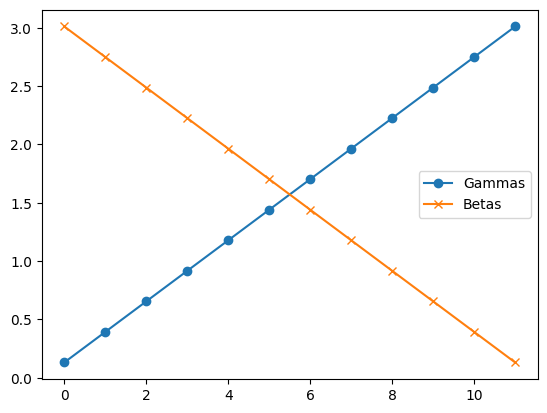

In [149]:
optimized_gammas = optimization_res.x[0::2]
optimized_betas = optimization_res.x[1::2]

plt.plot(optimized_gammas, label="Gammas", marker="o")
plt.plot(optimized_betas, label="Betas", marker="x")
plt.legend()

Accumulate the statistics with the final optimized parameters:

In [150]:
res = es.sample({"params": optimization_res.x.tolist()})

In [151]:
sorted_counts = sorted(res.parsed_counts, key=lambda pc: cost(pc.state["x"]))

for sampled in sorted_counts[:20]:
    x = sampled.state["x"]
    if check_validity(x):
        print(
            f"Valid solution={sampled.state['x']} probability={sampled.shots/NUM_SHOTS} cost={cost(sampled.state['x'])}"
        )
    else:
        print(
            f"Invalid solution={sampled.state['x']} probability={sampled.shots/NUM_SHOTS} cost={cost(sampled.state['x'])}"
        )

Valid solution=[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] probability=0.0016333333333333334 cost=0.07766708749355561
Valid solution=[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1] probability=0.0015666666666666667 cost=0.07766708749355561
Valid solution=[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0] probability=0.0015 cost=0.07766708749355561
Valid solution=[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0] probability=0.0013666666666666666 cost=0.07766708749355561
Valid solution=[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0] probability=0.0017666666666666666 cost=0.11675088242357473
Valid solution=[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0] probability=0.0015333333333333334 cost=0.11675088242357473
Valid solution=[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1] probability=0.0015 cost=0.11675088242357473
Valid solution=[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] probability=0.0012333333333333332 cost=0.11675088242357473
Valid solution=[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 

### Best Solution 

In [152]:
sorted_counts[0]

{'x': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]}: 49

In [153]:
visited_cities_by_vehicle = {}

for vehicle in depots:
    print("Vehicle:", vehicle)
    visited_cities_by_vehicle[vehicle] = []  # Initialize list for this vehicle

    for position in positions_all:
        for city in locations:
            if visit_indicator(sorted_counts[0].state["x"], city, position, vehicle):
                print(f"Visited in city {city} at position {position}")
                visited_cities_by_vehicle[vehicle].append(city)

Vehicle: 0
Visited in city 0 at position 0
Visited in city 2 at position 1
Visited in city 4 at position 2
Visited in city 0 at position 3
Vehicle: 1
Visited in city 1 at position 0
Visited in city 3 at position 1
Visited in city 5 at position 2
Visited in city 1 at position 3


Text(0.5, 1.0, 'Cities Colored by Visiting Vehicle + Directed Routes')

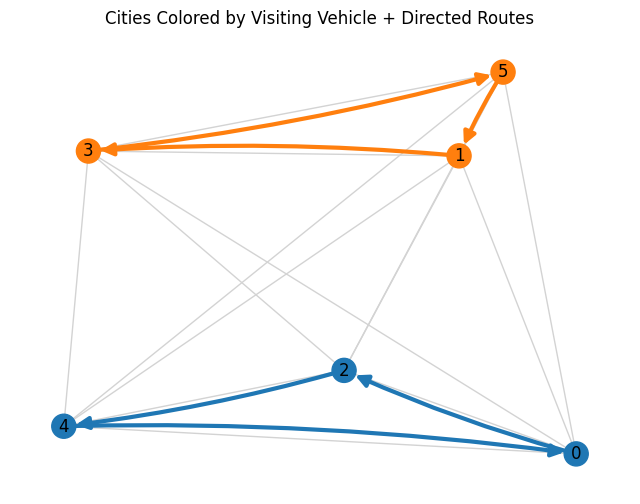

In [154]:
G = nx.complete_graph(num_locations)

color_map = plt.colormaps["tab10"]
vehicle_colors = {vehicle: color_map(i) for i, vehicle in enumerate(depots)}

city_colors = [None] * num_locations
for vehicle, cities in visited_cities_by_vehicle.items():
    for city in cities:
        city_colors[city] = vehicle_colors[vehicle]

# Cities plot
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=300,
    node_color=city_colors,
    edge_color="lightgray",
    ax=ax,
)

# Directed route for each vehicle
for i, (vehicle, cities) in enumerate(visited_cities_by_vehicle.items()):
    # Ensure order reflects travel order
    route = [c for c, _ in itertools.groupby(cities)]
    if len(route) < 2:
        continue

    edges = list(nx.utils.pairwise(route))

    # Slight curve per vehicle to separate overlapping edges
    rad = 0.08 * (i - (len(visited_cities_by_vehicle) - 1) / 2)

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges,
        edge_color=vehicle_colors[vehicle],
        width=3,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=18,
        connectionstyle=f"arc3,rad={rad}",
        ax=ax,
    )

plt.title("Cities Colored by Visiting Vehicle + Directed Routes")